In [466]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [467]:
# Reading finalized datasets
US_data = pd.read_csv(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\US_data.csv")
CO_emissions = pd.read_csv(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\CO_emissions.csv")

## Dataset 2 - Preprocessing

In [468]:
df2 = CO_emissions.copy()

In [469]:
df2['year'] = pd.to_datetime(df2['year'])

In [470]:
df2.set_index(df2['year'], inplace=True)

In [471]:
df2.drop(columns=['year'], inplace=True)

In [472]:
df2.shape

(120, 19)

In [473]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [474]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [475]:
dataset = df2
values = df2.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
print(reframed)

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.000000   0.529909   0.474903   0.000000   0.000000   0.000000   
2     0.010801   0.552596   0.519737   0.034651   0.005939   0.000778   
3     0.018749   0.535302   0.549220   0.056319   0.016694   0.001268   
4     0.042579   0.631557   0.614279   0.134516   0.025228   0.001759   
5     0.040022   0.471637   0.589181   0.120799   0.029605   0.002135   
..         ...        ...        ...        ...        ...        ...   
115   0.895721   0.539995   0.031189   0.696636   0.836973   0.851670   
116   0.868418   0.321670   0.021199   0.552378   0.847267   0.876756   
117   0.846441   0.353948   0.012914   0.473562   0.836973   0.883301   
118   0.839370   0.444286   0.005361   0.447967   0.856439   0.873133   
119   0.870695   0.676974   0.009747   0.413009   0.856439   0.968245   

     var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1     0.000000   0.000000   0.420078    0.00000

In [476]:
# split into train and test sets
values = reframed.values
n_train_hours = 35
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35, 1, 19) (35,) (84, 1, 19) (84,)


In [477]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/200
1/1 - 0s - loss: 0.2089 - val_loss: 0.7762
Epoch 2/200
1/1 - 0s - loss: 0.2030 - val_loss: 0.7696
Epoch 3/200
1/1 - 0s - loss: 0.1971 - val_loss: 0.7630
Epoch 4/200
1/1 - 0s - loss: 0.1912 - val_loss: 0.7563
Epoch 5/200
1/1 - 0s - loss: 0.1852 - val_loss: 0.7497
Epoch 6/200
1/1 - 0s - loss: 0.1793 - val_loss: 0.7430
Epoch 7/200
1/1 - 0s - loss: 0.1733 - val_loss: 0.7362
Epoch 8/200
1/1 - 0s - loss: 0.1674 - val_loss: 0.7295
Epoch 9/200
1/1 - 0s - loss: 0.1616 - val_loss: 0.7227
Epoch 10/200
1/1 - 0s - loss: 0.1558 - val_loss: 0.7159
Epoch 11/200
1/1 - 0s - loss: 0.1501 - val_loss: 0.7091
Epoch 12/200
1/1 - 0s - loss: 0.1445 - val_loss: 0.7023
Epoch 13/200
1/1 - 0s - loss: 0.1390 - val_loss: 0.6954
Epoch 14/200
1/1 - 0s - loss: 0.1334 - val_loss: 0.6886
Epoch 15/200
1/1 - 0s - loss: 0.1279 - val_loss: 0.6817
Epoch 16/200
1/1 - 0s - loss: 0.1223 - val_loss: 0.6748
Epoch 17/200
1/1 - 0s - loss: 0.1168 - val_loss: 0.6679
Epoch 18/200
1/1 - 0s - loss: 0.1115 - val_loss: 0.6609
E

Epoch 147/200
1/1 - 0s - loss: 0.0219 - val_loss: 0.3694
Epoch 148/200
1/1 - 0s - loss: 0.0218 - val_loss: 0.3684
Epoch 149/200
1/1 - 0s - loss: 0.0218 - val_loss: 0.3675
Epoch 150/200
1/1 - 0s - loss: 0.0217 - val_loss: 0.3665
Epoch 151/200
1/1 - 0s - loss: 0.0216 - val_loss: 0.3656
Epoch 152/200
1/1 - 0s - loss: 0.0216 - val_loss: 0.3647
Epoch 153/200
1/1 - 0s - loss: 0.0215 - val_loss: 0.3638
Epoch 154/200
1/1 - 0s - loss: 0.0214 - val_loss: 0.3628
Epoch 155/200
1/1 - 0s - loss: 0.0214 - val_loss: 0.3619
Epoch 156/200
1/1 - 0s - loss: 0.0213 - val_loss: 0.3609
Epoch 157/200
1/1 - 0s - loss: 0.0213 - val_loss: 0.3598
Epoch 158/200
1/1 - 0s - loss: 0.0212 - val_loss: 0.3586
Epoch 159/200
1/1 - 0s - loss: 0.0212 - val_loss: 0.3573
Epoch 160/200
1/1 - 0s - loss: 0.0211 - val_loss: 0.3559
Epoch 161/200
1/1 - 0s - loss: 0.0211 - val_loss: 0.3544
Epoch 162/200
1/1 - 0s - loss: 0.0210 - val_loss: 0.3529
Epoch 163/200
1/1 - 0s - loss: 0.0209 - val_loss: 0.3514
Epoch 164/200
1/1 - 0s - loss: 

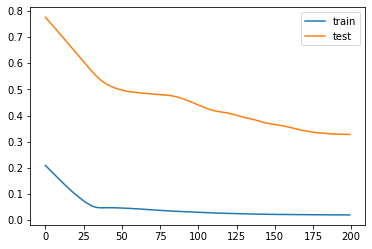

In [478]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [479]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1976.606
